In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Membuka Dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
#plot function
def plot_series(time, series, format="-", title="", label=None, start=0, end=None):
    """Plot the series"""
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(title)
    if label:
        plt.legend()
    plt.grid(True)

In [ ]:
#train val split function
def train_val_split(time, series, split_time):
  time_train = time[:split_time]
  series_train = series[:split_time]
  time_val = time[split_time:]
  series_val = series[split_time:]

  return time_train, series_train, time_val, series_val

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Group of Dataset/Bakery sales.csv')
df.head()

,Unnamed: 0,date,time,ticket_number,article,Quantity,unit_price
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     234005 non-null  int64  
 1   date           234005 non-null  object 
 2   time           234005 non-null  object 
 3   ticket_number  234005 non-null  float64
 4   article        234005 non-null  object 
 5   Quantity       234005 non-null  float64
 6   unit_price     234005 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 12.5+ MB


In [ ]:
df = df.drop(['time', 'ticket_number'], axis=1)

In [ ]:
df.isna().sum()

,0
Unnamed: 0,0
date,0
article,0
Quantity,0
unit_price,0


In [ ]:
df.duplicated().sum()

0

In [ ]:
df = df.drop('Unnamed: 0', axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 234005 entries, 0 to 234004
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        234005 non-null  object 
 1   article     234005 non-null  object 
 2   Quantity    234005 non-null  float64
 3   unit_price  234005 non-null  object 
dtypes: float64(1), object(3)
memory usage: 7.1+ MB


# Penjualan Tiap Hari

## Preprocess

In [ ]:
date_sales_df = df.groupby('date').sum().reset_index()
date_sales_df = date_sales_df.drop('article', axis=1)
date_sales_df['unit_price'] = date_sales_df['unit_price'].str.replace('€', '')
date_sales_df['unit_price'] = date_sales_df['unit_price'].str.replace(',', '.')
date_sales_df

,date,Quantity,unit_price
0,2021-01-02,581.0,0.90 1.20 1.20 1.15 1.20 0.90 1.10 1.05 1.20 1...
1,2021-01-03,564.0,1.20 1.05 0.45 1.20 1.20 5.00 1.10 1.20 8.00 2...
2,2021-01-04,315.0,1.20 1.20 1.20 1.20 1.05 1.20 1.80 0.90 0.15 1...
3,2021-01-05,309.0,0.90 1.10 1.10 0.90 0.45 1.20 1.50 1.10 1.00 1...
4,2021-01-07,310.0,1.20 1.10 1.00 1.20 0.90 6.50 1.25 1.40 1.20 1...
...,...,...,...
595,2022-09-26,399.0,1.30 1.30 1.20 1.30 1.30 1.20 1.30 1.30 2.00 1...
596,2022-09-27,423.0,0.15 1.30 1.20 1.80 1.15 1.30 1.60 1.30 1.30 1...
597,2022-09-28,357.0,1.00 1.30 1.00 1.30 1.15 1.20 1.15 1.00 1.30 1...
598,2022-09-29,428.0,1.30 1.70 1.30 1.20 1.30 1.30 0.70 1.60 1.70 1...


In [ ]:
date_sales_df_splitted = date_sales_df['unit_price'].str.split(' ')
date_sales_df_splitted

,unit_price
0,"[0.90, 1.20, 1.20, 1.15, 1.20, 0.90, 1.10, 1.0..."
1,"[1.20, 1.05, 0.45, 1.20, 1.20, 5.00, 1.10, 1.2..."
2,"[1.20, 1.20, 1.20, 1.20, 1.05, 1.20, 1.80, 0.9..."
3,"[0.90, 1.10, 1.10, 0.90, 0.45, 1.20, 1.50, 1.1..."
4,"[1.20, 1.10, 1.00, 1.20, 0.90, 6.50, 1.25, 1.4..."
...,...
595,"[1.30, 1.30, 1.20, 1.30, 1.30, 1.20, 1.30, 1.3..."
596,"[0.15, 1.30, 1.20, 1.80, 1.15, 1.30, 1.60, 1.3..."
597,"[1.00, 1.30, 1.00, 1.30, 1.15, 1.20, 1.15, 1.0..."
598,"[1.30, 1.70, 1.30, 1.20, 1.30, 1.30, 0.70, 1.6..."


In [ ]:
price_floated = []
for data in date_sales_df_splitted:
  price_data = []
  for price in data:
    if price == '':
      price_data.append(0)
    else:
      price_data.append(float(price))
  price_floated.append(round(sum(price_data), 2))

In [ ]:
price_floated[:5]

[716.95, 782.85, 340.0, 424.65, 428.3]

In [ ]:
date_sales_df['unit_price'] = price_floated
date_sales_df

,date,Quantity,unit_price
0,2021-01-02,581.0,716.95
1,2021-01-03,564.0,782.85
2,2021-01-04,315.0,340.00
3,2021-01-05,309.0,424.65
4,2021-01-07,310.0,428.30
...,...,...,...
595,2022-09-26,399.0,534.60
596,2022-09-27,423.0,622.95
597,2022-09-28,357.0,488.30
598,2022-09-29,428.0,496.40


In [ ]:
date_sales_df['day'] = np.arange(len(date_sales_df))

In [ ]:
TIME = date_sales_df['day']
#normalize series
SERIES = (date_sales_df['Quantity'] - min(date_sales_df['Quantity'])) / (max(date_sales_df['Quantity']) - min(date_sales_df['Quantity']))

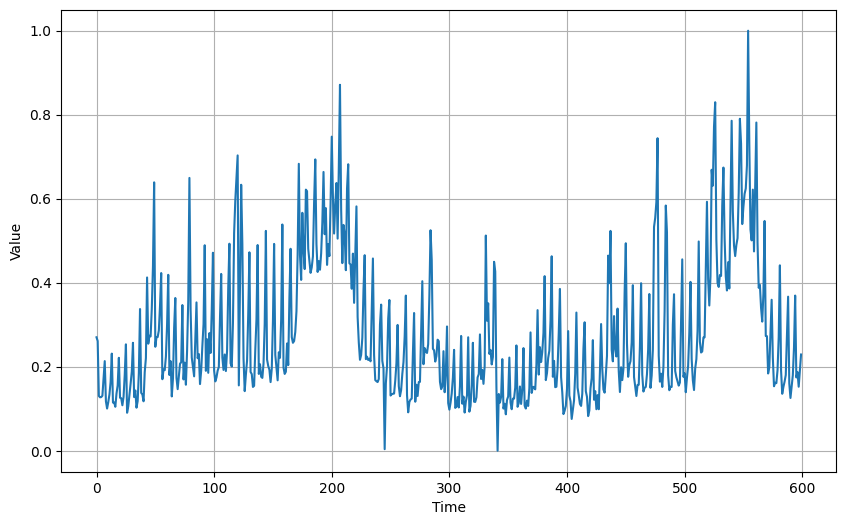

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(TIME, SERIES)
plt.show()

## Splitting Data

In [ ]:
SPLIT_NUM = 400

In [ ]:
time_train, series_train, time_val, series_val = train_val_split(TIME, SERIES, SPLIT_NUM)

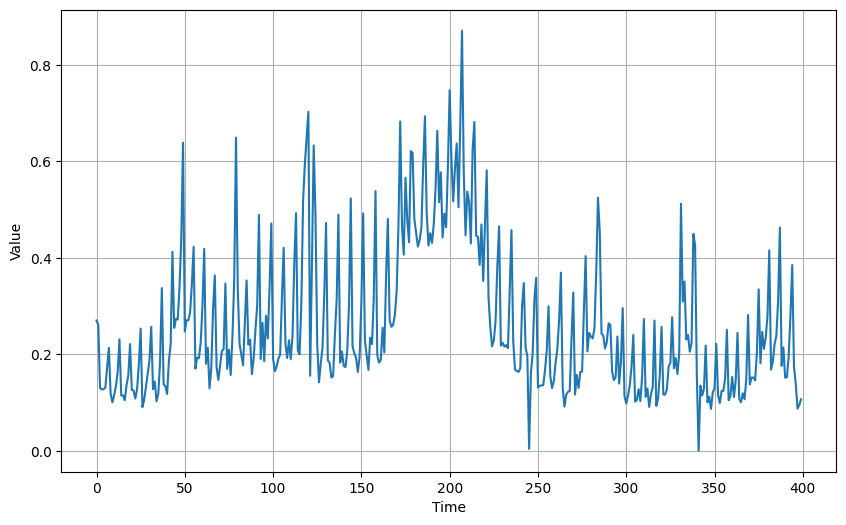

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_train, series_train)
plt.show()

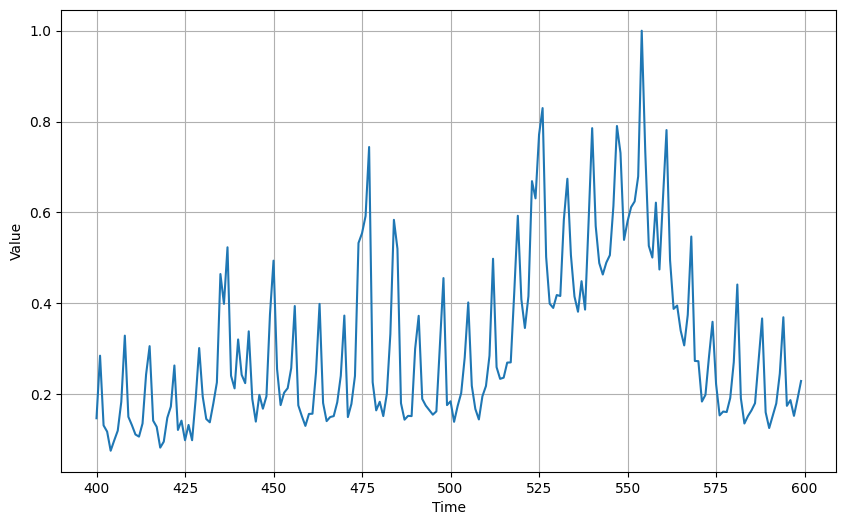

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plt.show()

## Naive Forecasting

In [ ]:
naive_forecast = SERIES[SPLIT_NUM-1:-1]

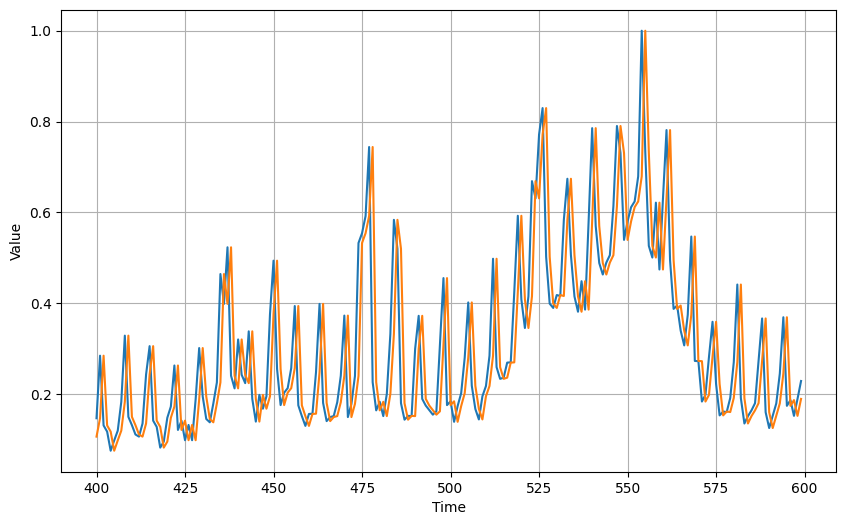

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plot_series(time_val, naive_forecast)
plt.show()

## Moving Average Forecasting

In [ ]:
def moving_average_forecast(series, window_size):
    forecast = []

    for time in range(len(series) - window_size):
      forecast.append(series[time:time + window_size].mean())

    forecast = np.array(forecast)

    return forecast

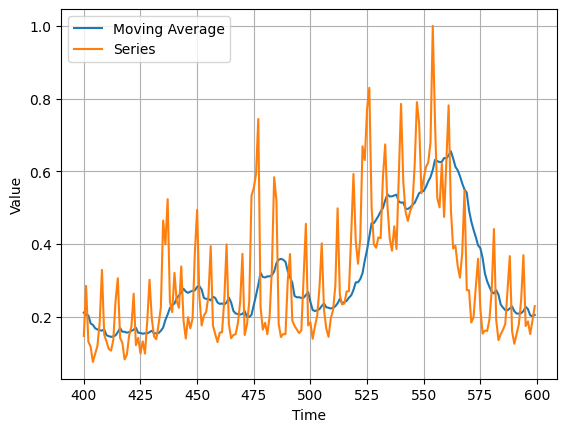

In [ ]:
moving_avg = moving_average_forecast(SERIES, 15)[SPLIT_NUM - 15:]

plot_series(time_val, moving_avg, label="Moving Average")
plot_series(time_val, series_val, label="Series")

In [ ]:
print(tf.keras.losses.mse(series_val, moving_avg).numpy())

0.019293443549488917


In [ ]:
print(tf.keras.losses.mae(series_val, moving_avg).numpy())

0.10383587318269401
